In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
# import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias, plot_results
from exp_hp import get_hp

2024-08-29 09:53:20.775266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 09:53:24.092162: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  0


In [3]:
#%% >>>>> Plot Accuracy & Loss during Training >>>>>
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])

def plot_results(n_epochs, epoch, patience, loss, loss_val, acc, acc_val, showplot=True):
    trainColor = 'k'
    valColor = (141/255,171/255,127/255,1.)
    FS = 14
    plt.figure(figsize=(15, 7))

    #---------- plot loss -------------------
    ax = plt.subplot(2,2,1)
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
    ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)

    plt.plot(acc, 'o', color=trainColor, label='Training',alpha=0.6)
    plt.plot(acc_val, 'o', color=valColor, label='Validation',alpha=0.6)
    plt.vlines((epoch+1)-patience,-10,1,'k',linestyle='dashed',alpha=0.4)

    plt.title('ACCURACY')
    plt.xlabel('EPOCH')
    plt.xticks(np.arange(0,120,20),labels=np.arange(0,120,20))
    plt.yticks(np.arange(.4,1.1,.1),labels=[0.4,0.5,0.6,0.7,0.8,0.9,1.0]) # 0,0.1,0.2,0.3,
    plt.grid(True)
    plt.legend(frameon=True, fontsize=FS)
    plt.xlim(-2, 100)
    plt.ylim(.4,1)
    
    # ---------- plot accuracy -------------------
    ax = plt.subplot(2,2,2)
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
    ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)
    
    plt.plot(loss, 'o', color=trainColor, label='Training',alpha=0.6)
    plt.plot(loss_val, 'o', color=valColor, label='Validation',alpha=0.6)
    plt.vlines((epoch+1)-patience,0,1,'k',linestyle='dashed',alpha=0.4)
    plt.title('PREDICTION LOSS')
    plt.xlabel('EPOCH')
    plt.legend(frameon=True, fontsize=FS)
    plt.xticks(np.arange(0, 120,20),labels=np.arange(0, 120,20))
    plt.yticks(np.arange(0,1.1,.1),labels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plt.ylim(0,1)
    plt.grid(True)
    plt.xlim(-2, 100)

    # ---------- Make the plot -------------------
    #plt.tight_layout()
    if showplot==False:
        plt.close('all')
    else:
        plt.show()

### Fuctions

In [5]:
def create_ann(input_shape, n_output, hiddens, RIDGE = 0, dropout = True, dropout_rate = 0.0):
    tf.keras.backend.clear_session() 

    # ----- input of cnn -----
    ann_input = keras.Input(shape = input_shape)

    for l,layer in enumerate(hiddens):
        # ----- ann layers -----
        if l == 0:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=RIDGE),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(ann_input)
            if dropout:
                x = layers.Dropout(rate = dropout_rate)(x)
        else:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
        
    # ----- output -----
    ann_output = tf.keras.layers.Dense(n_output,
                                       activation = tf.keras.activations.softmax,
                                       use_bias = True,
                                       kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                       bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                       kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
    # ----- create unet -----
    ann = keras.Model(ann_input, ann_output, name = 'ann')
    
    return ann

### Load standardized E3SM

In [6]:
EXP_NAME = 'exp2'
hps = get_hp(EXP_NAME)
print('Training Members: '+str(hps['train_mems']))
print('Validation Member: '+str(hps['val_mems'][0]))
print('Testing Member: '+str(hps['test_mems'][0]))
print('Lead: '+str(hps['LEAD']))
print('Region: '+str(hps['region'][0])+'N x '+str(hps['region'][1])+'E')

Training Members: ['0101', '0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181']
Validation Member: 0191
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E


In [7]:
%%time
Xtrain, Xval, _, Ytrain, Yval, _, _ = split_SDbias(trainmems = hps['train_mems'],
                                                      valmem = hps['val_mems'][0],
                                                      testmem = hps['test_mems'][0],
                                                      months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                      lead = hps['LEAD']) # 330 or 210

files do not exist - loading data & saving
CPU times: user 13.7 s, sys: 5.23 s, total: 18.9 s
Wall time: 25.7 s


In [8]:
Xval = Xval.reshape((Xval.shape[0],Xval.shape[1]*Xval.shape[2]))
Xtrain = Xtrain.reshape((Xtrain.shape[0],Xtrain.shape[1]*Xtrain.shape[2]))
input_shape = Xtrain.shape[1]

### Train NN

In [39]:
# ---------- ANN Hyperparameters ----------
NLABEL = 2
N_EPOCHS = 1000

HIDDENS = hps['HIDDENS']
BATCH_SIZE = 512#hps['BATCH_SIZE']
LR_INIT = hps['LR_INIT']
RIDGE = hps['RIDGE']
dropout_rate = 0.7 #hps['DROPOUT_RATE']
PATIENCE = 30 #hps['PATIENCE']
GLOBAL_SEED = hps['GLOBAL_SEED']
dropout_bool = True

In [40]:
print(HIDDENS,
      BATCH_SIZE,
      LR_INIT,
      RIDGE,
      dropout_rate,
      PATIENCE)

[128] 512 0.0001 0.0 0.7 30


In [41]:
# Create a dataset
dataset = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain)).shuffle(buffer_size=Ytrain.shape[0]).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((Xval, Yval)).batch(BATCH_SIZE)

0
Early stopping at epoch 73


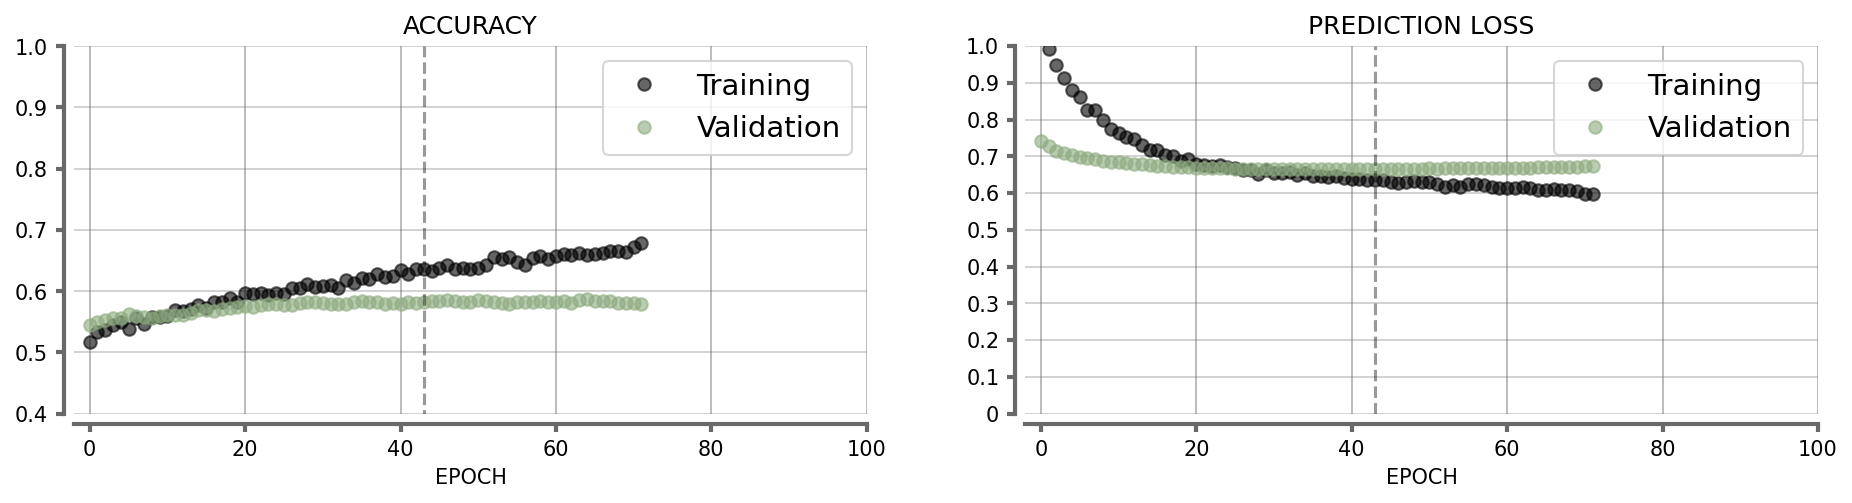

1
Early stopping at epoch 81


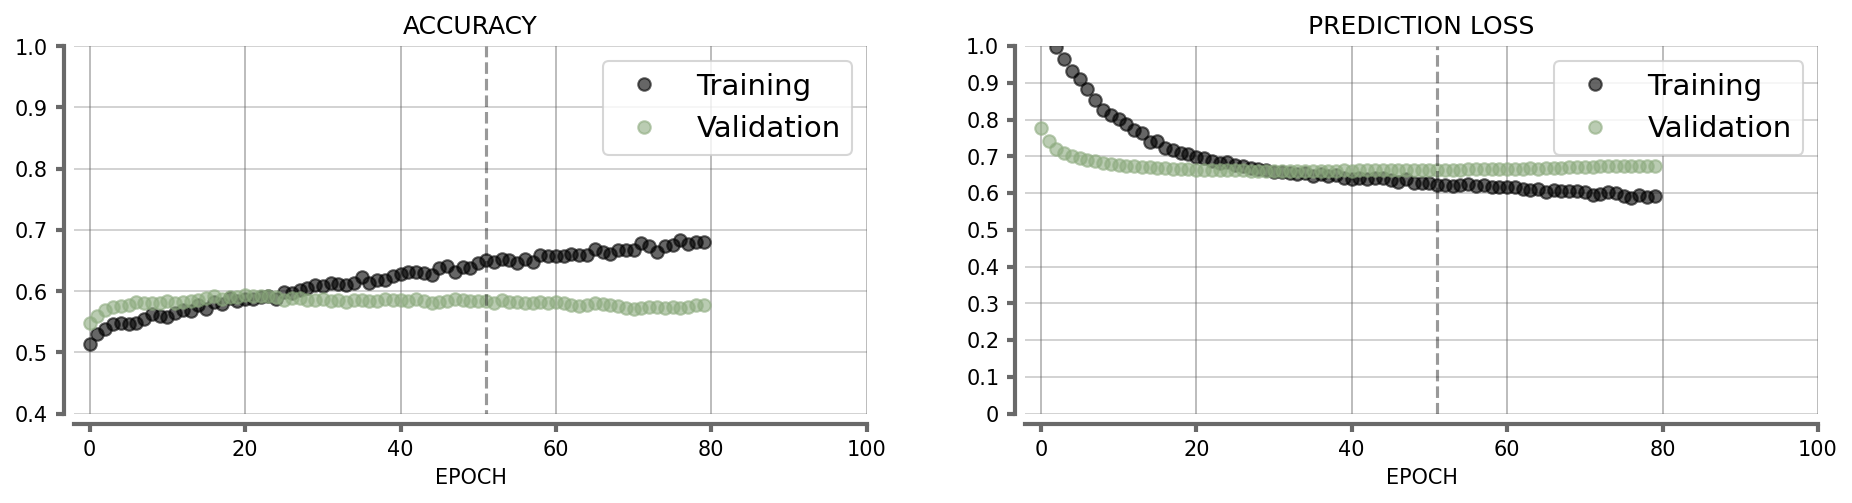

2
Early stopping at epoch 83


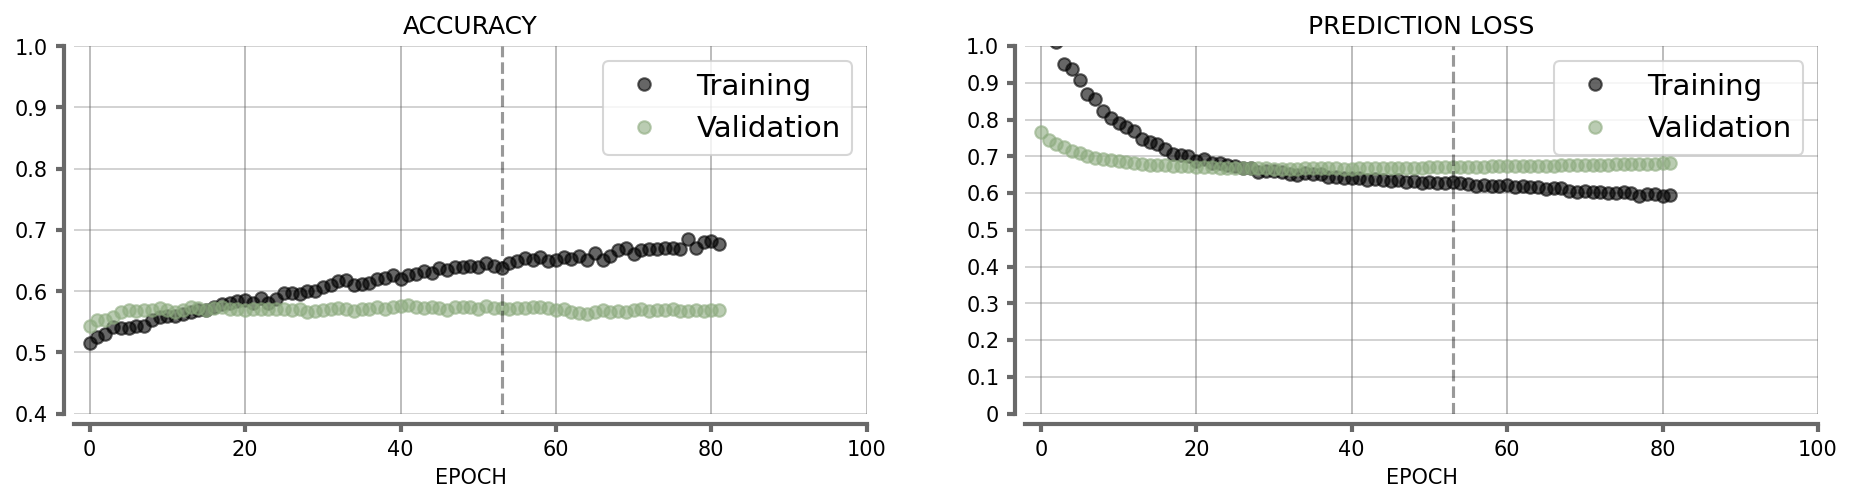

3
Early stopping at epoch 60


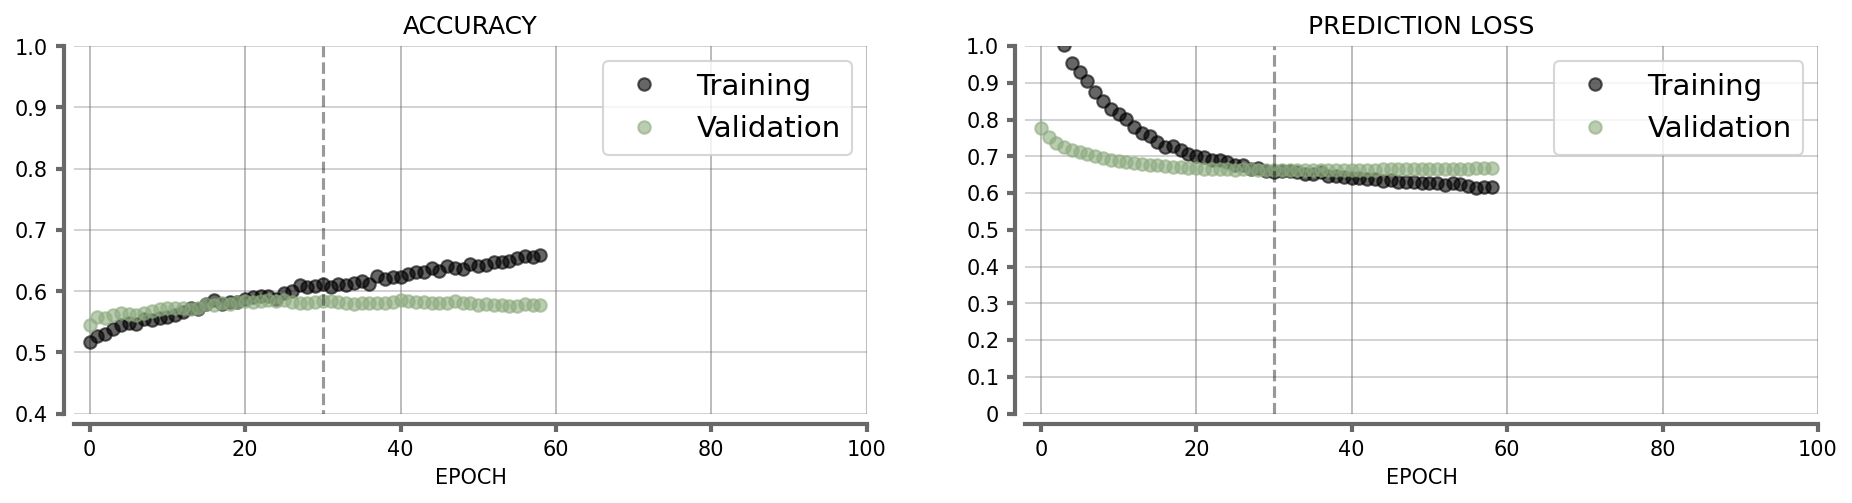

4
Early stopping at epoch 87


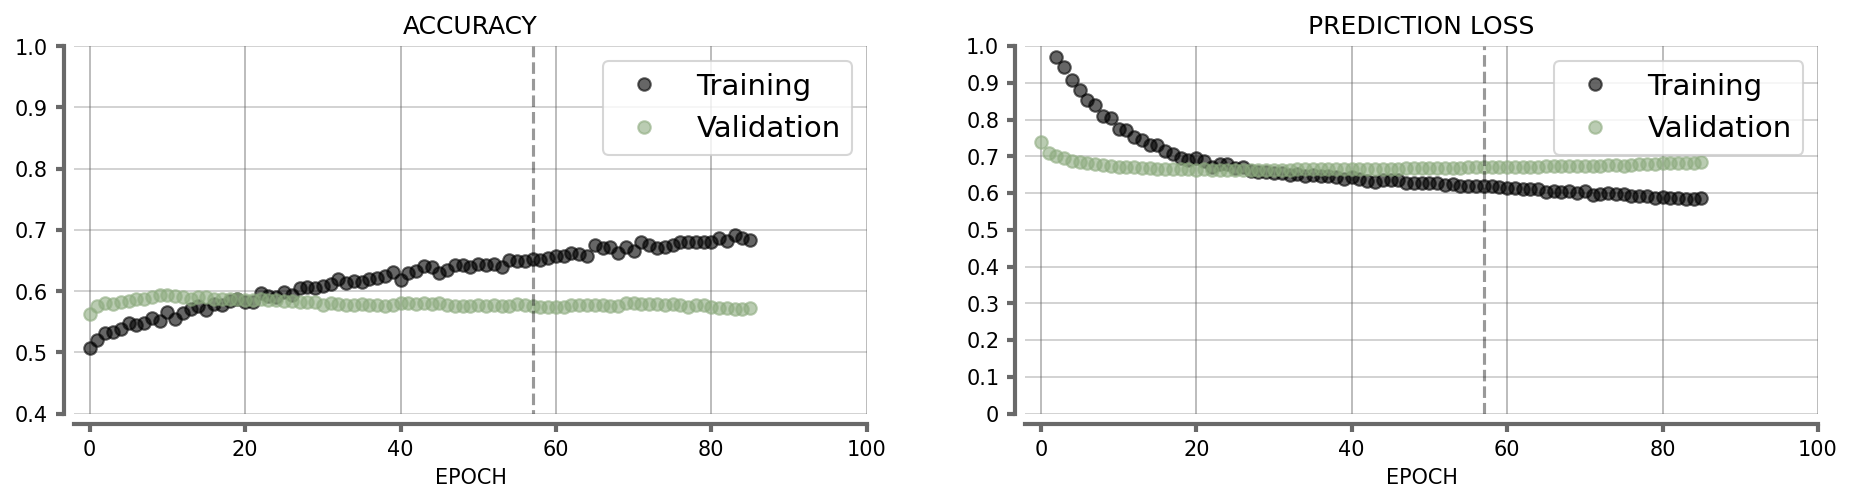

5
Early stopping at epoch 72


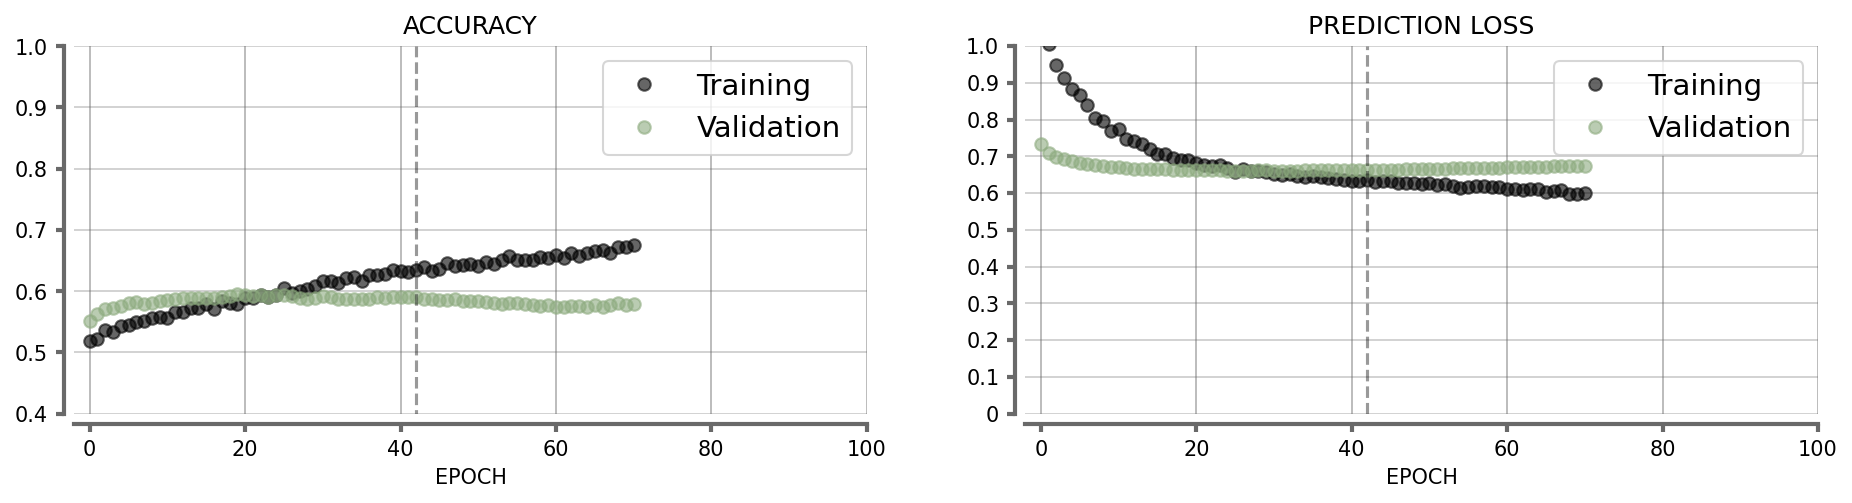

6
Early stopping at epoch 31


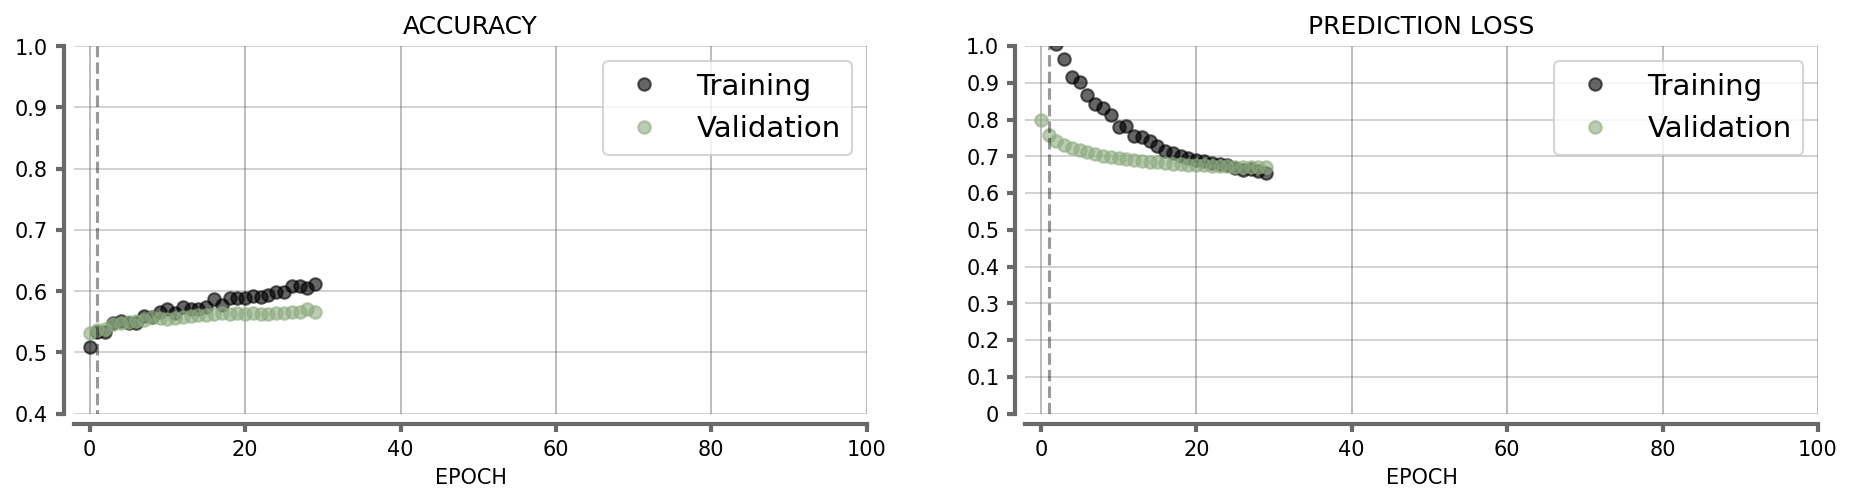

7
Early stopping at epoch 76


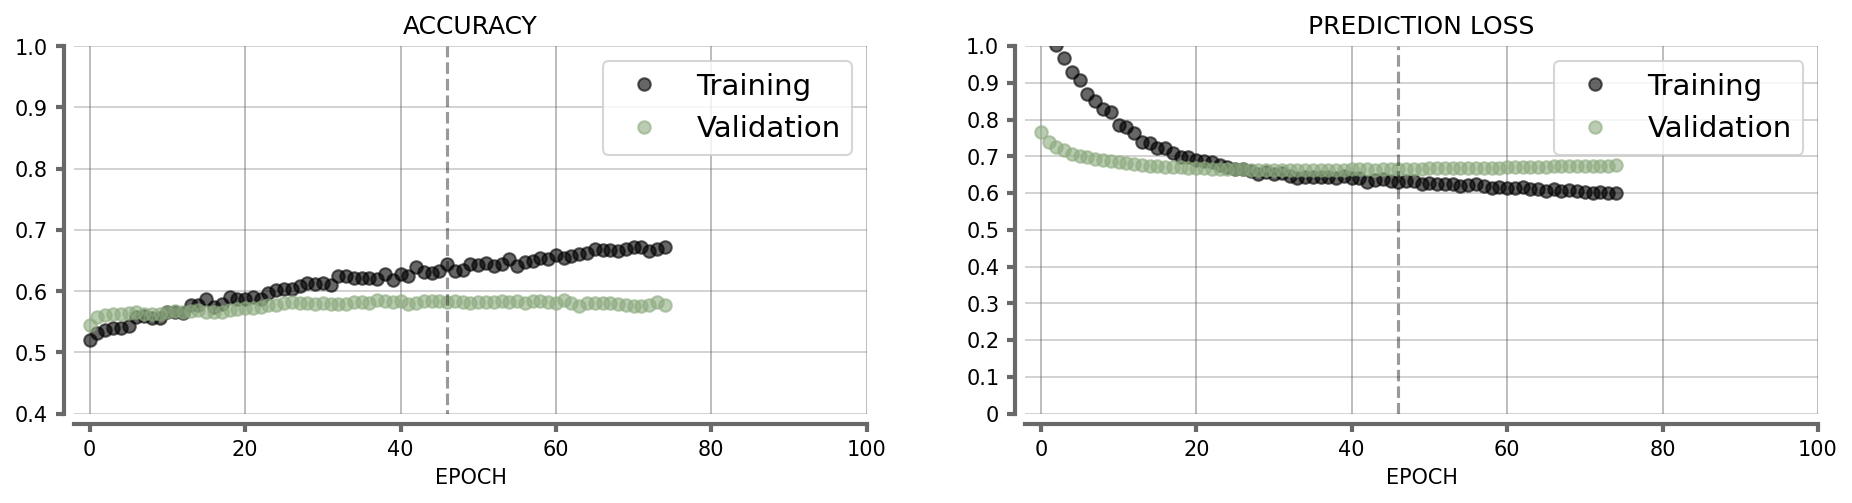

8
Early stopping at epoch 54


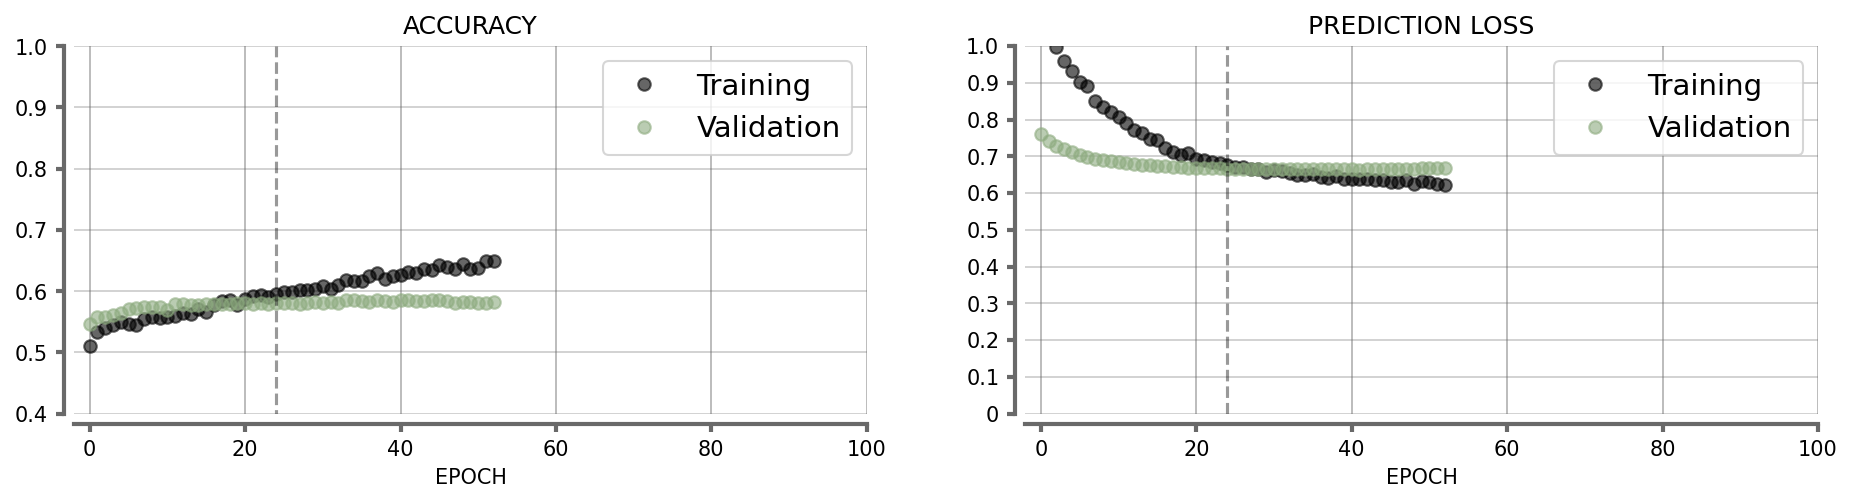

9
Early stopping at epoch 73


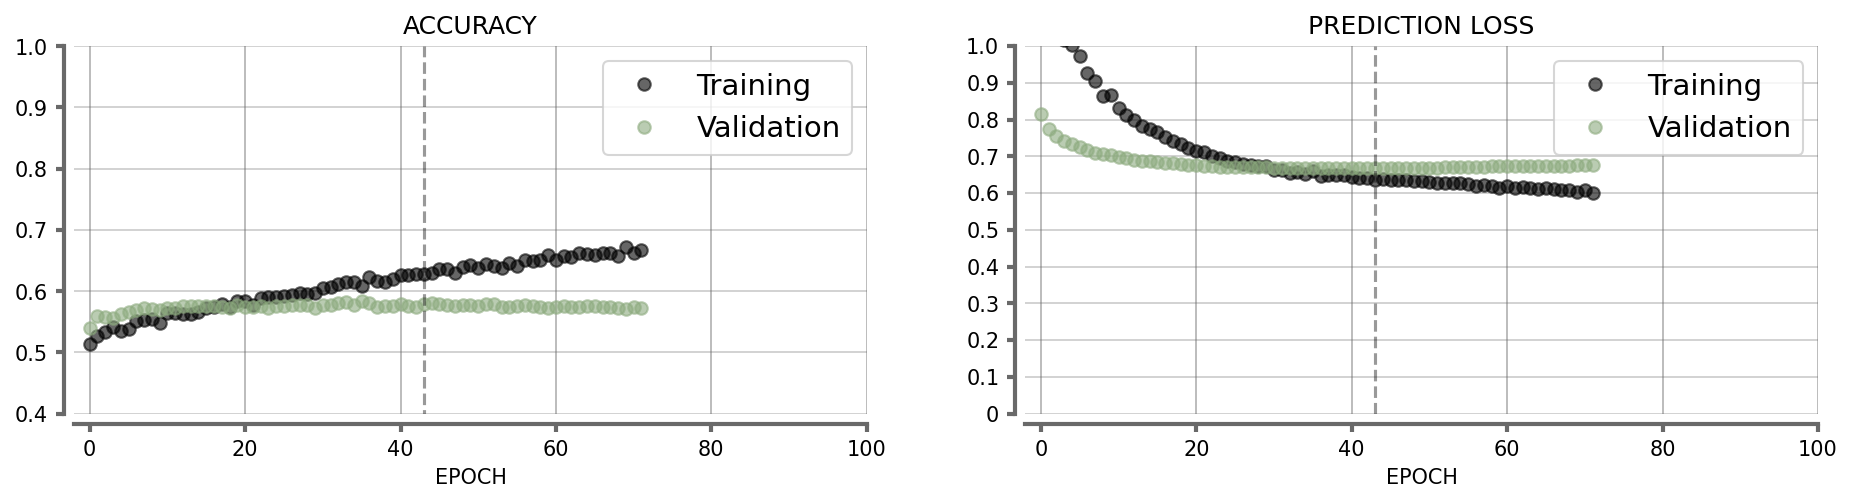

In [47]:
#----- SET UP & TRAIN NN -----
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)
    
for SEED in np.arange(0,10):
    print(SEED)
    tf.keras.backend.clear_session() 
    wait = 0
    best_val_loss = float('inf')
    best_weights = None

    @tf.function
    def train_step(X, y):
        with tf.GradientTape() as tape:
            predictions = model(X, training=True)
            loss = loss_fn(y, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_acc_metric.update_state(y, predictions)
        train_loss_metric.update_state(y, predictions)
        return loss
        
    @tf.function    
    def val_step(X, y):
        val_predictions = model(X, training=False)
        val_loss = loss_fn(y, val_predictions)
        val_acc_metric.update_state(y, val_predictions)
        val_loss_metric.update_state(y, val_predictions)
        return val_loss
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = LR_INIT,)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    
    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    train_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
    val_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()

    # ------ define NN ------
    model = create_ann(input_shape = input_shape,
                       n_output = 2,
                       hiddens=HIDDENS,
                       RIDGE = RIDGE,
                       dropout = dropout_bool, dropout_rate = dropout_rate)
        
    LOSS_LIST = []
    LOSS_VAL_LIST = []
    ACC_LIST  = []
    ACC_VAL_LIST  = []
    
    for epoch in range(N_EPOCHS):  # Number of epochs
        # print(f"Epoch {epoch + 1}")
        step = 0
        for batch_X, batch_y in dataset:
            loss = train_step(batch_X, batch_y)
            step += 1
            if step >= len(dataset) // 5:  # Stop after processing 1/5 of the batches
                break
        
        for batch_X_val, batch_y_val in val_dataset:
            val_loss = val_step(batch_X_val, batch_y_val)
    
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.get_weights()  # Save the best weights
            wait = 0  # Reset patience counter
        else:
            wait += 1
            if wait >= PATIENCE:
                print(f"Early stopping at epoch {epoch + 1}")
                model.set_weights(best_weights)  # Restore the best weights
                break

        ACC_LIST.append(float(train_acc_metric.result()))
        ACC_VAL_LIST.append(float(val_acc_metric.result()))
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        LOSS_LIST.append(float(train_loss_metric.result()))
        LOSS_VAL_LIST.append(float(val_loss_metric.result()))
        train_loss_metric.reset_states()
        val_loss_metric.reset_states()
        
    plot_results(N_EPOCHS, epoch, PATIENCE, LOSS_LIST, LOSS_VAL_LIST, ACC_LIST, ACC_VAL_LIST)

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), tf.keras.metrics.SparseCategoricalAccuracy()])
    annfi_name = 'ann_60Eshift_check_seed'+str(SEED)+'.h5'
    model.save(base_dir+'train/saved_models/'+annfi_name)